<a href="https://colab.research.google.com/github/zolfaShefreie/Spark_ML/blob/main/sparkML_customerChurn_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download dataset

In [1]:
import requests

In [2]:
customer_url = 'https://raw.githubusercontent.com/zolfaShefreie/Spark_ML/main/data.csv'
customer_file_path = "data.csv"

In [3]:
def download_file(url: str, file_path):
  """
  download file and save on file path
  """
  file_content = requests.get(url).text
  file = open(file_path, 'w')
  file.write(file_content)
  file.close()

In [4]:
download_file(customer_url, customer_file_path)

#pyspark setup

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 53.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ae239a3a397c5dcd40150f51b7edb41336646758bbf1c69c9d2b2ff627bd9f85
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [6]:
import pyspark
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.config("spark.driver.memory", "8g").appName('spark_ml').getOrCreate()
sc = spark.sparkContext

#imports

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce

In [9]:
from pyspark.sql.functions import col,isnan, when, count, lit, coalesce
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

#load data

In [10]:
df = spark.read.csv(customer_file_path, inferSchema=True, header=True)

In [11]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



#Analyse data

##basics

تعداد‌ها به تعداد سطر‌های کل دیتافریم نمی‌خوره

In [12]:
df.summary().show()

+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------+
|summary|customerID|gender|      SeniorCitizen|Partner|Dependents|           tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges| Label|
+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------+
|  count|    229737|229755|             229724| 229765|    229748| 

In [13]:
df.count()

229990

شمردن نال‌ها

In [14]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

طبق نتایج زیر نشون میده بعضی از سطرها در مجموعه داده بار‌ها تکرار شده‌اند. <br/>
زمانی این موضوع مفید است که از یک دسته از داده که برچسب یکسانی دارند دارای اطلاعات خیلی کمی هستند که باعث میشه مدل نتواند آن برچسب را به‌درستی آموزش بیند.<br/>

In [15]:
df.select(df.columns).groupBy(df.columns).count().show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|count|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|9356-AXGMP|  Male|          0.0|    Yes|  

In [16]:
df.select(df.columns).groupBy(df.columns).count().filter(col('count')>1).agg({'count': 'sum'}).show()

+----------+
|sum(count)|
+----------+
|    228579|
+----------+



In [17]:
df.dropDuplicates().count()

7838

بررسی اینکه به‌صورت متوازن این تکرار داده‌ها وجود داره و صدمه ای به نصبت میزند یا نه<br/>
طبق نتایج زیر این تکرار باعث شده این نسبت و توازن بین برچسب‌ها از بین رود بنابراین با اینکه این مورد 

In [18]:
df.select('Label').groupBy('Label').count().show()

+-----+------+
|Label| count|
+-----+------+
| null|   208|
|   No|195878|
|  Yes| 33904|
+-----+------+



In [19]:
df.dropDuplicates().select('Label').groupBy('Label').count().show()

+-----+-----+
|Label|count|
+-----+-----+
| null|  208|
|   No| 5681|
|  Yes| 1949|
+-----+-----+



In [20]:
195878/5681, 33904/1949, 195878/33904, 5681/1949

(34.47949304699877, 17.395587480759364, 5.777430391694195, 2.914828116983068)

سلول پایینی برای پیش پردازش داده به حساب میاد ولی به‌دلیل اینکه این نسبت تکرار ممکن است اثر بالایی بر روی پردازش اولیه داشته باشد به‌خصوص مواردی که در آن‌ها مد مهم است، در این قسمت انجام می‌شود.

In [21]:
df = df.dropDuplicates()

بررسی کد‌های اولیه با تغییر انجام شده

In [22]:
df.summary().show()

+-------+----------+------+-------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----------------+-----------------+-----+
|summary|customerID|gender|      SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|   MonthlyCharges|     TotalCharges|Label|
+-------+----------+------+-------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----------------+-----------------+-----+
|  count|      7585|  7603|               7572|   7613|      7596|       

In [23]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

پلات تمام وابستگی‌ها

In [24]:
categorical_cols = {'gender', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                    'PaymentMethod', 'Label', "Contract", "customerID"}

In [25]:
stages = list()
for column in categorical_cols:
    string_indexer = StringIndexer(inputCol=column, outputCol=column+"Index")
    # one_hot = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col+'CVect'])
    stages.append(string_indexer)

pipeline = Pipeline(stages=stages)
normalized_model = pipeline.fit(df.na.drop())
df2 = normalized_model.transform(df.na.drop())

In [26]:
df2.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+-------------+---------------+-----------------+-----------+------------------+--------------------+------------+-------------------+---------------+---------------------+---------------------+----------+--------------------+----------------+----------------+-----------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|MultipleLinesIndex|ContractIndex|customerIDIndex|PhoneServiceIndex|genderIndex|

In [27]:
vector_col = "corr_features"
columns = [column+"Index" for column in categorical_cols] + ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(df2).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


طبق نتایج:<br/>


*   مواردی که مربوط به داشتن اینترنت است یه رابطه‌ی مستقیمی باهم دارند که بهتر است در نظر گرفته شود
*   رابطه‌ی بین چند خط داشتن و سرویس موبایل نیز رابطه‌ی مستقی دارند
*   و برچسب رابطه‌ی مستقمی با بیشتر از داده‌ها ندارد در نگاه اول که بهتر است این وظیفه برعهده‌ی مدل گذاشته شود.



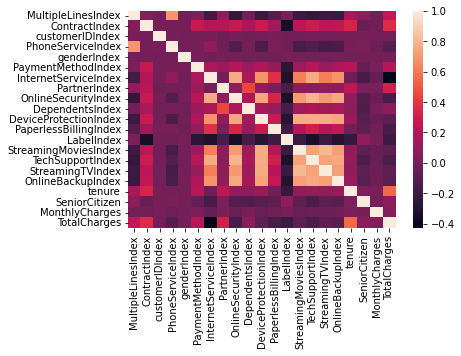

In [28]:
corr = matrix.collect()[0][matrix.columns[0]].toArray()
sns.heatmap(corr, 
            xticklabels=columns,
            yticklabels=columns)

##relation between seniorCitizen and phone and internet service

طبق نام ستون این ستون برای نشان دادن اینکه این فرد سالخورده است یا نه اما مقادیر ۱۴ و ۱۷ برای آن اشتباه است

In [29]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|          0.0| 6331|
|         null|  266|
|          1.0| 1232|
|         14.0|    8|
|         17.0|    1|
+-------------+-----+



حدس: بیشتر افراد سالخورده سرویس موبایل و یا سرویس اینترنت ندارند. طبق نتایج پایین حدس رد شد.

In [30]:
df.select(['SeniorCitizen', 'PhoneService']).\
filter((df.SeniorCitizen == 1) | (df.SeniorCitizen == 0)).\
groupBy(['SeniorCitizen', 'PhoneService']).count().show()

+-------------+------------+-----+
|SeniorCitizen|PhoneService|count|
+-------------+------------+-----+
|          0.0|        null|  142|
|          1.0|        null|   42|
|          1.0|         Yes| 1061|
|          0.0|          No|  635|
|          1.0|          No|  129|
|          0.0|         Yes| 5554|
+-------------+------------+-----+



In [31]:
df.select(['SeniorCitizen', 'InternetService']).\
filter((df.SeniorCitizen == 1) | (df.SeniorCitizen == 0)).\
groupBy(['SeniorCitizen', 'InternetService']).count().show()

+-------------+---------------+-----+
|SeniorCitizen|InternetService|count|
+-------------+---------------+-----+
|          0.0|           null|  127|
|          0.0|    Fiber optic| 2364|
|          1.0|           null|   26|
|          1.0|    Fiber optic|  862|
|          0.0|             No| 1589|
|          1.0|            DSL|  292|
|          1.0|             No|   52|
|          0.0|            DSL| 2251|
+-------------+---------------+-----+



کسانی که سرویس موبایل ندارند سرویس اینترنت فیبر ندارند (تمامی دی اس ال هستند) بااینکه مقادیری نال می‌باشد ولی می‌توان نتیجه گرفت کسانی که سرویس موبایل ندارند حتما سرویس اینترنت دارند و کسانی که سرویس اینترنت ندارند حتما سرویس موبایل دارند.

In [32]:
df.select(['PhoneService', 'InternetService']).\
groupBy(['PhoneService', 'InternetService']).count().show()

+------------+---------------+-----+
|PhoneService|InternetService|count|
+------------+---------------+-----+
|          No|            DSL|  768|
|        null|           null|   73|
|         Yes|             No| 1642|
|        null|    Fiber optic|   78|
|         Yes|            DSL| 1780|
|        null|             No|   58|
|          No|           null|   44|
|         Yes|           null|  113|
|         Yes|    Fiber optic| 3222|
|        null|            DSL|   60|
+------------+---------------+-----+



بیشتر افراد از نظر برچسب در حالت رها نکردن شرکت قرار دارند چه افراد سالخورده چه دیگر افراد

In [33]:
df.select(['SeniorCitizen', 'Label']).groupBy(['SeniorCitizen', 'Label']).count().show()

+-------------+-----+-----+
|SeniorCitizen|Label|count|
+-------------+-----+-----+
|          0.0| null|  123|
|         17.0|   No|    1|
|         null| null|   71|
|          1.0| null|   14|
|         14.0|  Yes|    2|
|          1.0|  Yes|  510|
|          0.0|   No| 4797|
|          1.0|   No|  708|
|         null|   No|  169|
|         null|  Yes|   26|
|          0.0|  Yes| 1411|
|         14.0|   No|    6|
+-------------+-----+-----+



مثل نتایج قبلی بیشتر افراد در دسته‌ها رها نکردند شرکت رو و بیشتر افراد چه رها کرده چه رها نکرده سرویس موبایل داشتند

In [34]:
df.select(['PhoneService', 'Label']).groupBy(['PhoneService', 'Label']).count().show()

+------------+-----+-----+
|PhoneService|Label|count|
+------------+-----+-----+
|         Yes|  Yes| 1737|
|        null| null|   74|
|          No|   No|  593|
|         Yes|   No| 4920|
|        null|   No|  168|
|          No| null|   34|
|        null|  Yes|   27|
|         Yes| null|  100|
|          No|  Yes|  185|
+------------+-----+-----+



بیشتر افرادی که رها نکردند دی اس ال داشتند و بیشتر افرادی که رها کردند فیبر داشتند

In [35]:
df.select(['InternetService', 'Label']).groupBy(['InternetService', 'Label']).count().show()

+---------------+-----+-----+
|InternetService|Label|count|
+---------------+-----+-----+
|            DSL|  Yes|  477|
|    Fiber optic|  Yes| 1345|
|           null| null|   66|
|             No|   No| 1538|
|    Fiber optic| null|   44|
|             No| null|   49|
|           null|   No|  150|
|           null|  Yes|   14|
|    Fiber optic|   No| 1911|
|             No|  Yes|  113|
|            DSL| null|   49|
|            DSL|   No| 2082|
+---------------+-----+-----+



##relation between PhoneService and MultipleLines

اگر شخصی سرویس موبایل نداشته باشد باید در این دو ستون یکسان ثبت شود بنابراین نال‌ها به راحتی پر می‌شوند و حالت نقض هم وجود ندارد

بیشتر افرادی که سرویس موبایل دارند چند خطه نیستند ولی این نسبت خیلی زیاد نیست

In [36]:
df.select(['MultipleLines', 'PhoneService']).groupBy(['MultipleLines', 'PhoneService']).count().show()

+----------------+------------+-----+
|   MultipleLines|PhoneService|count|
+----------------+------------+-----+
|No phone service|        null|   44|
|No phone service|          No|  768|
|             Yes|         Yes| 3089|
|            null|        null|   79|
|              No|        null|   80|
|            null|          No|   44|
|             Yes|        null|   66|
|            null|         Yes|  140|
|              No|         Yes| 3528|
+----------------+------------+-----+



بیشتر افرادی که رها کردند چند خطه بودند و بیشتر افرادی که رها نکردند چند خطه نبودند

In [37]:
df.select(['MultipleLines', 'Label']).groupBy(['MultipleLines', 'Label']).count().show()

+----------------+-----+-----+
|   MultipleLines|Label|count|
+----------------+-----+-----+
|No phone service| null|   32|
|No phone service|   No|  596|
|             Yes|  Yes|  892|
|            null| null|   73|
|              No|   No| 2702|
|             Yes|   No| 2216|
|No phone service|  Yes|  184|
|              No| null|   56|
|            null|   No|  167|
|             Yes| null|   47|
|            null|  Yes|   23|
|              No|  Yes|  850|
+----------------+-----+-----+



## relation between InternetService and columns that looks need internet service

In [38]:
internet_count=df.select('InternetService').groupBy('InternetService').count().withColumn('total_count', col('count')).drop('count')
internet_count.show()

+---------------+-----------+
|InternetService|total_count|
+---------------+-----------+
|           null|        230|
|    Fiber optic|       3300|
|             No|       1700|
|            DSL|       2608|
+---------------+-----------+



طبق نتایج زیر برخی از نال ها مربوط به نداشتن سرویس اینترنت می‌توانند پر شوند.<br/>
بیشتر افراد امنیت ندارند. 

In [39]:
df.select(['InternetService', 'OnlineSecurity']).groupBy(['InternetService', 'OnlineSecurity']).count().show()

+---------------+-------------------+-----+
|InternetService|     OnlineSecurity|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1242|
|    Fiber optic|                Yes|  872|
|           null|               null|   65|
|    Fiber optic|               null|   61|
|             No|No internet service| 1652|
|           null|                 No|   72|
|             No|               null|   48|
|           null|                Yes|   42|
|    Fiber optic|                 No| 2367|
|            DSL|               null|   56|
|            DSL|                 No| 1310|
|           null|No internet service|   51|
+---------------+-------------------+-----+



In [40]:
df.select(['InternetService', 'OnlineSecurity']).\
groupBy(['InternetService', 'OnlineSecurity']).count().\
join(internet_count, ['InternetService']).\
withColumn('percent', col('count')*100/col('total_count')).\
show()

+---------------+-------------------+-----+-----------+------------------+
|InternetService|     OnlineSecurity|count|total_count|           percent|
+---------------+-------------------+-----+-----------+------------------+
|    Fiber optic|                 No| 2367|       3300| 71.72727272727273|
|    Fiber optic|               null|   61|       3300|1.8484848484848484|
|    Fiber optic|                Yes|  872|       3300|26.424242424242426|
|             No|               null|   48|       1700| 2.823529411764706|
|             No|No internet service| 1652|       1700| 97.17647058823529|
|            DSL|                 No| 1310|       2608| 50.23006134969325|
|            DSL|               null|   56|       2608| 2.147239263803681|
|            DSL|                Yes| 1242|       2608|47.622699386503065|
+---------------+-------------------+-----+-----------+------------------+



بیشتر افراد از نظر برچسب امنیت نداشتند و رها نکردند پس بهتر است با مد پر شود

In [41]:
df.select(['OnlineSecurity', 'Label']).groupBy(['OnlineSecurity', 'Label']).count().show()

+-------------------+-----+-----+
|     OnlineSecurity|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1542|
|                Yes|  Yes|  310|
|               null| null|   65|
|                 No|   No| 2185|
|                Yes|   No| 1811|
|               null|   No|  143|
|                 No| null|   60|
|                Yes| null|   35|
|               null|  Yes|   22|
|                 No|  Yes| 1504|
|No internet service|  Yes|  113|
|No internet service| null|   48|
+-------------------+-----+-----+



نال‌های مربوط به نداشتن سرویس اینترنتی راحت پر می‌شوند. بیشتر افراد بک‌آپ ندارند. با نسبت ۶۰ به ۴۰ که برای هر دو نوع صدق می‌کند 

In [42]:
df.select(['InternetService', 'OnlineBackup']).groupBy(['InternetService', 'OnlineBackup']).count().show()

+---------------+-------------------+-----+
|InternetService|       OnlineBackup|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1160|
|    Fiber optic|                Yes| 1386|
|           null|               null|   78|
|    Fiber optic|               null|   61|
|             No|No internet service| 1651|
|             No|               null|   49|
|           null|                 No|   63|
|           null|                Yes|   41|
|    Fiber optic|                 No| 1853|
|            DSL|               null|   55|
|            DSL|                 No| 1393|
|           null|No internet service|   48|
+---------------+-------------------+-----+



In [43]:
df.select(['InternetService', 'OnlineBackup']).\
groupBy(['InternetService', 'OnlineBackup']).count().\
join(internet_count, ['InternetService']).\
withColumn('percent', col('count')*100/col('total_count')).\
show()

+---------------+-------------------+-----+-----------+------------------+
|InternetService|       OnlineBackup|count|total_count|           percent|
+---------------+-------------------+-----+-----------+------------------+
|            DSL|                Yes| 1160|       2608| 44.47852760736196|
|    Fiber optic|                Yes| 1386|       3300|              42.0|
|    Fiber optic|               null|   61|       3300|1.8484848484848484|
|             No|No internet service| 1651|       1700| 97.11764705882354|
|             No|               null|   49|       1700|2.8823529411764706|
|    Fiber optic|                 No| 1853|       3300| 56.15151515151515|
|            DSL|               null|   55|       2608|2.1088957055214723|
|            DSL|                 No| 1393|       2608| 53.41257668711656|
+---------------+-------------------+-----+-----------+------------------+



بیشتر افراد بک آپ ندارند پس بهتر از مقادیر نال با استفاده از مد پر شود اگر با ستون‌های دیگر رابطه ای نداشته باشد (به جز دسته‌ی ذکر شده)

In [44]:
df.select('OnlineBackup').groupBy('OnlineBackup').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+------------------+
|       OnlineBackup|count|           percent|
+-------------------+-----+------------------+
|               null|  243|  3.10028068384792|
|                 No| 3309| 42.21740239857107|
|                Yes| 2587| 33.00586884409288|
|No internet service| 1699|21.676448073488135|
+-------------------+-----+------------------+



بیشتر افرادی که رها کردند بک آپ نداشتند اما بیشتر افرادی که رها نکردند بک آپ داشتند

In [45]:
df.select(['OnlineBackup', 'Label']).groupBy(['OnlineBackup', 'Label']).count().show()

+-------------------+-----+-----+
|       OnlineBackup|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1527|
|                Yes|  Yes|  534|
|               null| null|   57|
|                 No|   No| 1975|
|                Yes|   No| 2021|
|               null|   No|  158|
|                 No| null|   60|
|               null|  Yes|   28|
|                Yes| null|   32|
|                 No|  Yes| 1274|
|No internet service|  Yes|  113|
|No internet service| null|   59|
+-------------------+-----+-----+



نتایج مانند مورد قبلی

In [46]:
df.select(['InternetService', 'DeviceProtection']).groupBy(['InternetService', 'DeviceProtection']).count().show()

+---------------+-------------------+-----+
|InternetService|   DeviceProtection|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1079|
|    Fiber optic|                Yes| 1415|
|           null|               null|   76|
|    Fiber optic|               null|   68|
|             No|No internet service| 1649|
|             No|               null|   51|
|           null|                 No|   75|
|           null|                Yes|   35|
|    Fiber optic|                 No| 1817|
|            DSL|               null|   59|
|            DSL|                 No| 1470|
|           null|No internet service|   44|
+---------------+-------------------+-----+



In [47]:
df.select('DeviceProtection').groupBy('DeviceProtection').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+-----------------+
|   DeviceProtection|count|          percent|
+-------------------+-----+-----------------+
|               null|  254|3.240622607808114|
|                 No| 3362|42.89359530492472|
|                Yes| 2529|32.26588415412095|
|No internet service| 1693|21.59989793314621|
+-------------------+-----+-----------------+



در هر دسته از برچسب بیشتر پروتکشن نداشتند

In [48]:
df.select(['DeviceProtection', 'Label']).groupBy(['DeviceProtection', 'Label']).count().show()

+-------------------+-----+-----+
|   DeviceProtection|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1534|
|                Yes|  Yes|  575|
|               null| null|   72|
|                 No|   No| 2057|
|                Yes|   No| 1929|
|               null|   No|  161|
|                 No| null|   65|
|               null|  Yes|   21|
|                Yes| null|   25|
|                 No|  Yes| 1240|
|No internet service|  Yes|  113|
|No internet service| null|   46|
+-------------------+-----+-----+



بیشتر افراد سرویس تک ندارند.  بیشتر افرادی که تک دارند دی اس ال دارند و بیشتر افرادی که تک ندارند فیبر دارند<br />


In [49]:
df.select(['InternetService', 'TechSupport']).groupBy(['InternetService', 'TechSupport']).count().show()

+---------------+-------------------+-----+
|InternetService|        TechSupport|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1235|
|    Fiber optic|                Yes|  900|
|           null|               null|   91|
|    Fiber optic|               null|   52|
|             No|No internet service| 1643|
|             No|               null|   57|
|           null|                 No|   65|
|           null|                Yes|   36|
|    Fiber optic|                 No| 2348|
|            DSL|               null|   64|
|            DSL|                 No| 1309|
|           null|No internet service|   38|
+---------------+-------------------+-----+



از تک برای پر کردن اینترنت سرویس می‌توان استفاده کرد

In [50]:
df.select('TechSupport').groupBy('TechSupport').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+------------------+
|        TechSupport|count|           percent|
+-------------------+-----+------------------+
|               null|  264| 3.368206175044654|
|                 No| 3722| 47.48660372544016|
|                Yes| 2171|27.698392447052818|
|No internet service| 1681| 21.44679765246236|
+-------------------+-----+------------------+



بیشتر افراد تک ساپورت نداشتند پس بهتر است با مد پر شود

In [51]:
df.select(['TechSupport', 'Label']).groupBy(['TechSupport', 'Label']).count().show()

+-------------------+-----+-----+
|        TechSupport|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1517|
|                Yes|  Yes|  310|
|               null| null|   55|
|                 No|   No| 2152|
|                Yes|   No| 1825|
|               null|   No|  187|
|                 No| null|   66|
|                Yes| null|   36|
|               null|  Yes|   22|
|                 No|  Yes| 1504|
|No internet service|  Yes|  113|
|No internet service| null|   51|
+-------------------+-----+-----+



بیشتر افرادی که دی اس ال دارند استریم تی وی ندارند و بیشتر افرادی که فیبر هستند استریم تی وی دارند

In [52]:
df.select(['InternetService', 'StreamingTV']).groupBy(['InternetService', 'StreamingTV']).count().show()

+---------------+-------------------+-----+
|InternetService|        StreamingTV|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1022|
|    Fiber optic|                Yes| 1825|
|           null|               null|   71|
|    Fiber optic|               null|   66|
|             No|No internet service| 1653|
|           null|                 No|   55|
|             No|               null|   47|
|           null|                Yes|   57|
|    Fiber optic|                 No| 1409|
|            DSL|               null|   65|
|            DSL|                 No| 1521|
|           null|No internet service|   47|
+---------------+-------------------+-----+



In [53]:
df.select('StreamingTV').groupBy('StreamingTV').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+-----------------+
|        StreamingTV|count|          percent|
+-------------------+-----+-----------------+
|               null|  249|3.176830824189844|
|                 No| 2985|38.08369482010717|
|                Yes| 2904| 37.0502679254912|
|No internet service| 1700|21.68920643021179|
+-------------------+-----+-----------------+



بیشتر افراد استریم تی وی نداشتند و بشتر افراد رها نکردند

In [54]:
df.select(['StreamingTV', 'Label']).groupBy(['StreamingTV', 'Label']).count().show()

+-------------------+-----+-----+
|        StreamingTV|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1538|
|                Yes|  Yes|  827|
|               null| null|   62|
|                 No|   No| 1961|
|                Yes|   No| 2028|
|                 No| null|   48|
|               null|   No|  154|
|               null|  Yes|   33|
|                Yes| null|   49|
|                 No|  Yes|  976|
|No internet service|  Yes|  113|
|No internet service| null|   49|
+-------------------+-----+-----+



مثل نتایج مورد قبلی اونایی که دی اس ال دارند استریم مووی ندارند و بیشتر کسانی که فیبر دارند استریم مووی دارند

In [55]:
df.select(['InternetService', 'StreamingMovies']).groupBy(['InternetService', 'StreamingMovies']).count().show()

+---------------+-------------------+-----+
|InternetService|    StreamingMovies|count|
+---------------+-------------------+-----+
|            DSL|                Yes| 1066|
|    Fiber optic|                Yes| 1792|
|           null|               null|   65|
|    Fiber optic|               null|   55|
|             No|No internet service| 1649|
|             No|               null|   51|
|           null|                 No|   62|
|           null|                Yes|   50|
|    Fiber optic|                 No| 1453|
|            DSL|               null|   48|
|            DSL|                 No| 1494|
|           null|No internet service|   53|
+---------------+-------------------+-----+



In [56]:
df.select('StreamingMovies').groupBy('StreamingMovies').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+------------------+
|    StreamingMovies|count|           percent|
+-------------------+-----+------------------+
|               null|  219|2.7940801224802247|
|                 No| 3009|38.389895381474865|
|                Yes| 2908| 37.10130135238581|
|No internet service| 1702|21.714723143659096|
+-------------------+-----+------------------+



بیشتر کسانی که رها نکردند این سرویس رو داشتند و بیشتر کسانی که رها کردند این سرویس رو نداشتند

In [57]:
df.select(['StreamingMovies', 'Label']).groupBy(['StreamingMovies', 'Label']).count().show()

+-------------------+-----+-----+
|    StreamingMovies|Label|count|
+-------------------+-----+-----+
|No internet service|   No| 1533|
|                Yes|  Yes|  834|
|               null| null|   54|
|                 No|   No| 1975|
|                Yes|   No| 2028|
|                 No| null|   52|
|               null|   No|  145|
|               null|  Yes|   20|
|                Yes| null|   46|
|                 No|  Yes|  982|
|No internet service|  Yes|  113|
|No internet service| null|   56|
+-------------------+-----+-----+



##relation between StreamingMovies and StreamingTV

بیشتر رابطه ی مستقیم بین این دو مشاهده می‌شود اما چون استنثناهایی دیده میشود و حدود این یک پنجم داده می باشد نمی توان آن را به عنوان قانون عنوان کرد و یکی از مقادیر را پاک کرد

In [58]:
df.select(['StreamingTV', 'StreamingMovies']).groupBy(['StreamingTV', 'StreamingMovies']).count().show()

+-------------------+-------------------+-----+
|        StreamingTV|    StreamingMovies|count|
+-------------------+-------------------+-----+
|                Yes|                Yes| 2042|
|               null|               null|   72|
|                 No|                 No| 2140|
|                Yes|                 No|  806|
|No internet service|No internet service| 1655|
|                 No|               null|   46|
|               null|                 No|   63|
|                Yes|               null|   56|
|               null|                Yes|   67|
|                 No|                Yes|  799|
|               null|No internet service|   47|
|No internet service|               null|   45|
+-------------------+-------------------+-----+



##relation between OnlineSecurity and OnlineBackup and DeviceProtection

افرادی که امنیت دارند بیشتر بک آپ هم دارند ولی افرادی که امنیت ندارند بیشتر بک آپ هم ندارند.<br/>
بیشتر افراد هم امنیت ندارند

In [59]:
df.select(['OnlineSecurity', 'OnlineBackup']).groupBy(['OnlineSecurity', 'OnlineBackup']).count().show()

+-------------------+-------------------+-----+
|     OnlineSecurity|       OnlineBackup|count|
+-------------------+-------------------+-----+
|                Yes|                Yes| 1160|
|               null|               null|   61|
|                 No|                 No| 2296|
|                Yes|                 No|  942|
|No internet service|No internet service| 1649|
|                 No|               null|   74|
|               null|                 No|   71|
|               null|                Yes|   48|
|                Yes|               null|   54|
|                 No|                Yes| 1379|
|               null|No internet service|   50|
|No internet service|               null|   54|
+-------------------+-------------------+-----+



بیشتر افرادی که امنیت دارند پروتکشن هم دارند ولی بیشتر افرادی که امنیت ندارند پروتکشن هم ندارند

In [60]:
df.select(['OnlineSecurity', 'DeviceProtection']).groupBy(['OnlineSecurity', 'DeviceProtection']).count().show()

+-------------------+-------------------+-----+
|     OnlineSecurity|   DeviceProtection|count|
+-------------------+-------------------+-----+
|                Yes|                Yes| 1120|
|               null|               null|   72|
|                 No|                 No| 2298|
|                Yes|                 No|  988|
|No internet service|No internet service| 1643|
|                 No|               null|   74|
|               null|                 No|   76|
|               null|                Yes|   32|
|                Yes|               null|   48|
|                 No|                Yes| 1377|
|No internet service|               null|   60|
|               null|No internet service|   50|
+-------------------+-------------------+-----+



بیشتر افرادی که دیوایس پروتکشن ندارند بک آپ هم ندارند و بیشتر افرادی که دیوایس پروتکشن دارند بک آپ هم دارند. این قضیه برعکس هم صادق است

In [61]:
df.select(['DeviceProtection', 'OnlineBackup']).groupBy(['DeviceProtection', 'OnlineBackup']).count().show()

+-------------------+-------------------+-----+
|   DeviceProtection|       OnlineBackup|count|
+-------------------+-------------------+-----+
|                Yes|                Yes| 1355|
|               null|               null|   73|
|                 No|                 No| 2092|
|                Yes|                 No| 1141|
|No internet service|No internet service| 1641|
|               null|                 No|   76|
|                 No|               null|   85|
|               null|                Yes|   47|
|                Yes|               null|   33|
|                 No|                Yes| 1185|
|               null|No internet service|   58|
|No internet service|               null|   52|
+-------------------+-------------------+-----+



طبق نتایج زیر بیشتر افراد هر سه مورد رو ندارند. رتبه‌ی بعدی برای افرادیه که حداقل دوتاش رو دارند و رتبه‌ی سوم فقط دیوایس پروتکشن دارند و در آخر کسانی که هر سه مورد را دارند

In [62]:
df.select(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']).groupBy(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']).count().show()

+-------------------+-------------------+-------------------+-----+
|     OnlineSecurity|       OnlineBackup|   DeviceProtection|count|
+-------------------+-------------------+-------------------+-----+
|                Yes|                Yes|                 No|  452|
|               null|                Yes|                Yes|   13|
|                Yes|                Yes|               null|   12|
|                Yes|               null|                Yes|    5|
|               null|               null|               null|   22|
|                 No|                 No|               null|   32|
|                 No|               null|                 No|   35|
|               null|                 No|                 No|   36|
|                Yes|               null|                 No|   31|
|                Yes|                 No|               null|   18|
|               null|                Yes|                 No|   21|
|                 No|                Yes|       

##relation between Partner and Dependents and SeniorCitizen

حدس: کسی که پارنتر داره صد در صد خویشاوند نیز دارد. رد شد<br/>
اما بیشتر کسانی که پارتنر ندارند خوشاوند هم ندارند و بیشتر کسانی که خویشاوند دارند پارتنر هم دارند 

In [63]:
df.select(['Partner', 'Dependents']).groupBy(['Partner', 'Dependents']).count().show()

+-------+----------+-----+
|Partner|Dependents|count|
+-------+----------+-----+
|    Yes|       Yes| 1874|
|   null|      null|   64|
|     No|        No| 3489|
|    Yes|        No| 1704|
|     No|      null|  101|
|   null|        No|   99|
|   null|       Yes|   62|
|    Yes|      null|   77|
|     No|       Yes|  368|
+-------+----------+-----+



بیشتر افراد پارتنر ندارند اگر رابطه ای با لیبل نداشته باشد بهتر است با مد پر شود

In [64]:
df.select(['Partner', 'SeniorCitizen']).groupBy(['Partner', 'SeniorCitizen']).count().show()

+-------+-------------+-----+
|Partner|SeniorCitizen|count|
+-------+-------------+-----+
|   null|          0.0|  127|
|    Yes|          0.0| 2967|
|   null|         null|   70|
|    Yes|         14.0|    4|
|   null|          1.0|   28|
|    Yes|         17.0|    1|
|     No|          0.0| 3237|
|     No|         null|  101|
|    Yes|         null|   95|
|     No|         14.0|    4|
|     No|          1.0|  616|
|    Yes|          1.0|  588|
+-------+-------------+-----+



بیشتر افرادی که رها کردند پارتنر ندارند اما بیشتر افرادی که رها نکردند پارتنر دارند.

In [65]:
df.select(['Partner', 'Label']).groupBy(['Partner', 'Label']).count().show()

+-------+-----+-----+
|Partner|Label|count|
+-------+-----+-----+
|    Yes|  Yes|  702|
|   null| null|   60|
|     No|   No| 2658|
|    Yes|   No| 2887|
|     No| null|   82|
|   null|   No|  136|
|    Yes| null|   66|
|   null|  Yes|   29|
|     No|  Yes| 1218|
+-------+-----+-----+



بیشتر افراد خویشاوند ندارند، پس بهتر است با مد پر شود

In [66]:
df.select(['SeniorCitizen', 'Dependents']).groupBy(['SeniorCitizen', 'Dependents']).count().show()

+-------------+----------+-----+
|SeniorCitizen|Dependents|count|
+-------------+----------+-----+
|          0.0|      null|  133|
|         17.0|        No|    1|
|         null|      null|   72|
|          1.0|      null|   37|
|         14.0|       Yes|    2|
|          1.0|       Yes|   91|
|          0.0|        No| 4058|
|          1.0|        No| 1104|
|         null|        No|  123|
|         null|       Yes|   71|
|          0.0|       Yes| 2140|
|         14.0|        No|    6|
+-------------+----------+-----+



In [67]:
df.select('Dependents').groupBy('Dependents').count().show()

+----------+-----+
|Dependents|count|
+----------+-----+
|      null|  242|
|        No| 5292|
|       Yes| 2304|
+----------+-----+



In [68]:
df.select(['Dependents', 'Label']).groupBy(['Dependents', 'Label']).count().show()

+----------+-----+-----+
|Dependents|Label|count|
+----------+-----+-----+
|       Yes|  Yes|  343|
|      null| null|   64|
|        No|   No| 3623|
|       Yes|   No| 1912|
|      null|   No|  146|
|        No| null|   95|
|      null|  Yes|   32|
|       Yes| null|   49|
|        No|  Yes| 1574|
+----------+-----+-----+



##relations between tenure and MonthlyCharges and TotalCharges

In [69]:
tenure_list = [each.tenure for each in df.select('tenure').filter(~col('tenure').isNull()).collect()]

مقادیر منفی غیرقابل قبوله

In [70]:
min(tenure_list), max(tenure_list)

(-598.0, 72.0)

{'boxes': [<matplotlib.lines.Line2D at 0x7f779bac0ad0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f779bac4b10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f779baccb50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f779bacc610>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f779bac4090>,
  <matplotlib.lines.Line2D at 0x7f779bac45d0>]}

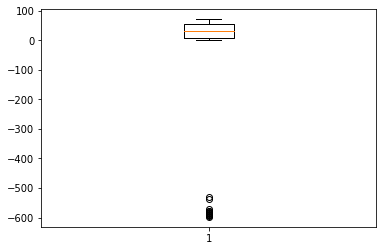

In [71]:
plt.boxplot(tenure_list)

(array([8.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.238e+03, 1.514e+03, 1.045e+03, 1.059e+03,
        9.600e+02, 1.782e+03]),
 array([-598. , -584.6, -571.2, -557.8, -544.4, -531. , -517.6, -504.2,
        -490.8, -477.4, -464. , -450.6, -437.2, -423.8, -410.4, -397. ,
        -383.6, -370.2, -356.8, -343.4, -330. , -316.6, -303.2, -289.8,
        -276.4, -263. , -249.6, -236.2, -222.8, -209.4, -196. , -182.6,
        -169.2, -155.8, -142.4, -129. , -115.6, -102.2,  -88.8,  -75.4,
         -62. , 

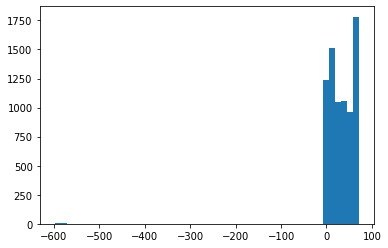

In [72]:
plt.hist(tenure_list, bins=50)

نشون میده یه سری مقادیر غیر قابل قبوله برای شارژ ماهیانه چون حتی از مجموع هم بالاتره

In [73]:
MonthlyCharges_list = [each.MonthlyCharges for each in df.select('MonthlyCharges').filter(~col('MonthlyCharges').isNull()).collect()]

{'boxes': [<matplotlib.lines.Line2D at 0x7f779bc22b50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f779c11ca90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f779c11db90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f779bbd6c10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f779bbbee90>,
  <matplotlib.lines.Line2D at 0x7f779bb3cf50>]}

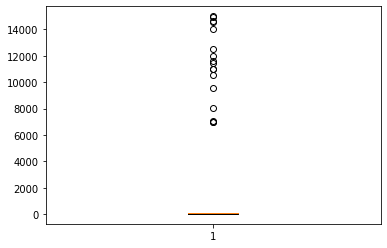

In [74]:
plt.boxplot(MonthlyCharges_list)

In [75]:
min(MonthlyCharges_list), max(MonthlyCharges_list)

(18.25, 14990.0)

(array([7.578e+03, 0.000e+00, 4.000e+00, 7.000e+00, 6.000e+00]),
 array([   18.25,  3012.6 ,  6006.95,  9001.3 , 11995.65, 14990.  ]),
 <a list of 5 Patch objects>)

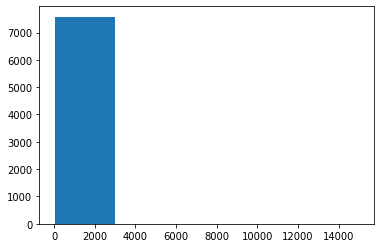

In [76]:
plt.hist(MonthlyCharges_list, bins=5)

In [77]:
TotalCharges_list = [each.TotalCharges for each in df.select('TotalCharges').filter(~col('TotalCharges').isNull()).collect()]

{'boxes': [<matplotlib.lines.Line2D at 0x7f779b947a10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f779b94ea10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f779b956a50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f779b956510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f779b947f50>,
  <matplotlib.lines.Line2D at 0x7f779b94e4d0>]}

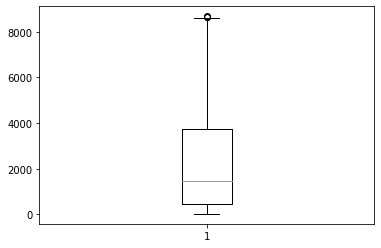

In [78]:
plt.boxplot(TotalCharges_list)

(array([4190., 1376.,  934.,  742.,  345.]),
 array([  18.8, 1752. , 3485.2, 5218.4, 6951.6, 8684.8]),
 <a list of 5 Patch objects>)

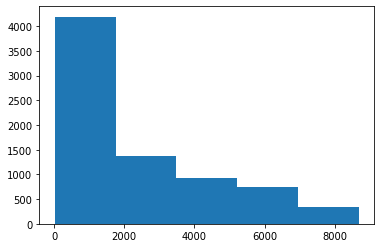

In [79]:
plt.hist(TotalCharges_list, bins=5)

In [80]:
condition = ((~col('TotalCharges').isNull())&(~col('MonthlyCharges').isNull())&(~col('tenure').isNull())&((~col('Label').isNull()))&
             (col('MonthlyCharges')<1000) & (col('tenure')>0))

In [81]:
tenure_list = [each.tenure for each in df.select('tenure').filter(condition).collect()]
MonthlyCharges_list = [each.MonthlyCharges for each in df.select('MonthlyCharges').filter(condition).collect()]
TotalCharges_list = [each.TotalCharges for each in df.select('TotalCharges').filter(condition).collect()]
label_list = [each.Label for each in df.select('Label').filter(condition).collect()]

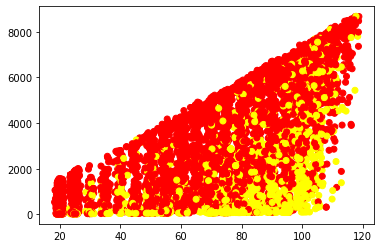

In [82]:
colors = {'No': 'red', "Yes": 'yellow'}
# plt.figure(figsize=(20, 10))
plt.scatter(MonthlyCharges_list, TotalCharges_list, c=[colors[x] for x in label_list])

تقریبا رو یک خط راست قرار گرفته اگه دقیقا از فرمول پیروی کنه میشه توتال چارچ رو حذف کرد چون اطلاعاتی که میده تقریبا یکیه

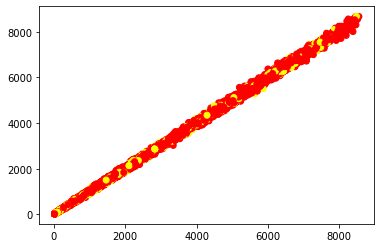

In [83]:
plt.scatter([x*y for x, y in zip(MonthlyCharges_list, tenure_list)], TotalCharges_list, c=[colors[x] for x in label_list])

In [84]:
line_condition = (col('tenure')*col('MonthlyCharges')==col('TotalCharges'))
df.filter(condition & line_condition).count()

611

طبق نتایج دقیقا برابر نیست که نشون میده می‌تونه تغییراتی شارژ ماهیانه در ماه‌های مختلف داشته باشه ولی مقادیر نال رو تقریبا میشه با این قانون پر کرد و بقیه موارد رو با میانگین

In [85]:
df.filter(condition & (~line_condition)).count()

6590

In [86]:
condition = ((col('TotalCharges').isNull())&(col('MonthlyCharges').isNull())&(col('tenure').isNull()))
df.filter(condition).count()

15

##relation between PaperlessBilling and PaymentMethod

حدس: فقط برای میل چک ستون دیگر حالت خیر دارد. حدس رد شد اما فقط توی حالت میلدچک هست که بیشتر مقدار نه هستش بقیه موارد توی حالت یس قرار دارند

In [87]:
df.select(['PaymentMethod', 'PaperlessBilling']).groupBy(['PaymentMethod', 'PaperlessBilling']).count().show()

+--------------------+----------------+-----+
|       PaymentMethod|PaperlessBilling|count|
+--------------------+----------------+-----+
|Credit card (auto...|            null|   31|
|                null|            null|   84|
|Credit card (auto...|              No|  642|
|        Mailed check|            null|   23|
|Bank transfer (au...|              No|  702|
|        Mailed check|             Yes|  663|
|Bank transfer (au...|            null|   48|
|Credit card (auto...|             Yes|  960|
|                null|              No|   40|
|                null|             Yes|  122|
|    Electronic check|              No|  625|
|    Electronic check|             Yes| 1885|
|Bank transfer (au...|             Yes|  927|
|    Electronic check|            null|   71|
|        Mailed check|              No| 1015|
+--------------------+----------------+-----+



In [88]:
df.select('PaymentMethod').groupBy('PaymentMethod').count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...| 1633|
|                null|  246|
|        Mailed check| 1701|
|Bank transfer (au...| 1677|
|    Electronic check| 2581|
+--------------------+-----+



بیشتر ترک نکردند 

In [89]:
df.select(['PaymentMethod', 'Label']).groupBy(['PaymentMethod', 'Label']).count().show()

+--------------------+-----+-----+
|       PaymentMethod|Label|count|
+--------------------+-----+-----+
|Credit card (auto...| null|   22|
|                null| null|   65|
|Credit card (auto...|   No| 1367|
|        Mailed check| null|   28|
|Bank transfer (au...|   No| 1379|
|        Mailed check|  Yes|  308|
|Bank transfer (au...| null|   40|
|Credit card (auto...|  Yes|  244|
|                null|   No|  152|
|                null|  Yes|   29|
|    Electronic check|   No| 1418|
|    Electronic check|  Yes| 1110|
|Bank transfer (au...|  Yes|  258|
|    Electronic check| null|   53|
|        Mailed check|   No| 1365|
+--------------------+-----+-----+



In [90]:
df.select('PaperlessBilling').groupBy('PaperlessBilling').count().show()

+----------------+-----+
|PaperlessBilling|count|
+----------------+-----+
|            null|  257|
|              No| 3024|
|             Yes| 4557|
+----------------+-----+



بیشتر افراد پیپر لس بیل داشتند

In [91]:
df.select(['PaperlessBilling', 'Label']).groupBy(['PaperlessBilling', 'Label']).count().show()

+----------------+-----+-----+
|PaperlessBilling|Label|count|
+----------------+-----+-----+
|             Yes|  Yes| 1451|
|            null| null|   66|
|              No|   No| 2510|
|             Yes|   No| 3007|
|            null|   No|  164|
|              No| null|   43|
|            null|  Yes|   27|
|             Yes| null|   99|
|              No|  Yes|  471|
+----------------+-----+-----+



## relation between PaymentMethod and Contract

طبق نتایج زیر:

*   بیشتر در حالت پرداخت با الکترونیک چک و میل چک ماه به ماه قرار داد هستش
*   برای باقی حالت‌ها قرارداد بیشتر دو ساله ست
*   توی حالت قرار داد یکساله  کریدت کارت و دوساله بانک ترانسفر بیشترین و توی حالت ماه به ماه الکرونیک چک بالاترین تعداد رو داره



In [92]:
df.select(['PaymentMethod', 'Contract']).groupBy(['PaymentMethod', 'Contract']).count().show()

+--------------------+--------------+-----+
|       PaymentMethod|      Contract|count|
+--------------------+--------------+-----+
|Credit card (auto...|          null|   32|
|        Mailed check|      One year|  336|
|                null|Month-to-month|   59|
|        Mailed check|      Two year|  439|
|                null|          null|   70|
|                null|      One year|   24|
|        Mailed check|          null|   23|
|Bank transfer (au...|      One year|  393|
|Bank transfer (au...|Month-to-month|  597|
|                null|      Two year|   93|
|Bank transfer (au...|          null|   44|
|Bank transfer (au...|      Two year|  643|
|    Electronic check|      Two year|  214|
|Credit card (auto...|      One year|  429|
|Credit card (auto...|      Two year|  602|
|    Electronic check|          null|   61|
|        Mailed check|Month-to-month|  903|
|    Electronic check|Month-to-month| 1923|
|Credit card (auto...|Month-to-month|  570|
|    Electronic check|      One 

#data preprocess and feature engineering

##missing value and outlier handling

###customerID and handle some null values based on this column

تعداد مقادیر نال در این ستون

In [93]:
df.select(count(when(isnan("customerID") | col("customerID").isNull(), "customerID")).alias('customerID')).show()

+----------+
|customerID|
+----------+
|       253|
+----------+



چون یکمی غیرعادی است که آیدی یا شناسه نال باشد چند ستون از آن چک می‌شود

مقادیر نال با مقدار دیگری پر نمی‌شود زیرا این ستون در انتها برای آموزش مدل حذف خواهد شد زیرا مدل براساس پارامترها تصمیم میگیرد برای برچسب دهی و این ستون شناسه ی مشتری می‌باشد 

In [94]:
df.filter(col('customerID').isNull()).show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|      null|  null|          0.0|   null|       Yes|  64.0|  

بررسی یونیک بودن شناسه:<br/>
طبق نتایج زیر شناسه‌ها یونیک نیستند و نشان‌دهنده‌ی این است که اطلاعات یک مشتری ممکن است در سطر‌های مختلف وجود داشته باشد.

In [95]:
df.select('customerID').groupBy('customerID').count().filter(col('count')>1).count()

23

In [96]:
df.select('customerID').groupBy('customerID').count().filter(col('count')>1).agg({'count': 'sum'}).show()

+----------+
|sum(count)|
+----------+
|       795|
+----------+



In [97]:
df.filter(col('customerID').isNotNull()).select('customerID').groupBy('customerID').count().filter(col('count')>1).show()

+--------------+-----+
|    customerID|count|
+--------------+-----+
|2928-HLDBAcsas|    4|
|3774-VBNXYcsas|   43|
|6217-KDYWCcsas|   17|
|8402-OOOHJcsas|   29|
|6497-TILVLcsas|    5|
|9445-ZUEQEcsas|   16|
|2876-GZYZCcsas|   11|
|2639-UGMAZcsas|   40|
|1091-SOZGAcsas|   38|
|5712-AHQNNcsas|   29|
|6734-PSBAWcsas|   54|
|6207-WIOLXcsas|   16|
|7799-LGRDPcsas|   35|
|4412-YLTKFcsas|   19|
|9560-BBZXKcsas|   19|
|7850-VWJUUcsas|   18|
|4622-YNKIJcsas|   22|
|8587-XYZSFcsas|   44|
|7219-TLZHOcsas|    3|
|4846-WHAFZcsas|   24|
+--------------+-----+
only showing top 20 rows



به نظر میرسه بعضی از آیتم ها یکی هستند ولی بعضی از موارد آن دستکاری شده و تبدیل به نال شده است پس با مرج این داده‌ها سطر کامل‌تری برای یک هویت درست می‌شود

In [98]:
df.filter(col('customerID')=='2928-HLDBAcsas').show()

+--------------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------+--------------+------------+-----+
|    customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+--------------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------+--------------+------------+-----+
|2928-HLDBAcsas|  null|          0.0|     No|      null|   6.0|        null|   

In [99]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|          0.0| 6331|
|         null|  266|
|          1.0| 1232|
|         14.0|    8|
|         17.0|    1|
+-------------+-----+



In [100]:
df_min_null = df.filter(col('customerID').isNotNull()).groupBy('customerID').agg({column: 'max' for column in df.columns if column != 'customerID'})

In [101]:
name_cols = [(f'max({column})', column) for column in df.columns if column != 'customerID']
name_cols

[('max(gender)', 'gender'),
 ('max(SeniorCitizen)', 'SeniorCitizen'),
 ('max(Partner)', 'Partner'),
 ('max(Dependents)', 'Dependents'),
 ('max(tenure)', 'tenure'),
 ('max(PhoneService)', 'PhoneService'),
 ('max(MultipleLines)', 'MultipleLines'),
 ('max(InternetService)', 'InternetService'),
 ('max(OnlineSecurity)', 'OnlineSecurity'),
 ('max(OnlineBackup)', 'OnlineBackup'),
 ('max(DeviceProtection)', 'DeviceProtection'),
 ('max(TechSupport)', 'TechSupport'),
 ('max(StreamingTV)', 'StreamingTV'),
 ('max(StreamingMovies)', 'StreamingMovies'),
 ('max(Contract)', 'Contract'),
 ('max(PaperlessBilling)', 'PaperlessBilling'),
 ('max(PaymentMethod)', 'PaymentMethod'),
 ('max(MonthlyCharges)', 'MonthlyCharges'),
 ('max(TotalCharges)', 'TotalCharges'),
 ('max(Label)', 'Label')]

In [102]:
df_min_null = reduce(lambda df_min_null, idx: df_min_null.withColumnRenamed(name_cols[idx][0], name_cols[idx][1]), range(len(name_cols)), df_min_null)

In [103]:
df_min_null.columns

['customerID',
 'DeviceProtection',
 'Partner',
 'TechSupport',
 'StreamingTV',
 'PhoneService',
 'Contract',
 'tenure',
 'InternetService',
 'SeniorCitizen',
 'PaperlessBilling',
 'MonthlyCharges',
 'OnlineBackup',
 'Label',
 'TotalCharges',
 'OnlineSecurity',
 'MultipleLines',
 'StreamingMovies',
 'Dependents',
 'PaymentMethod',
 'gender']

In [104]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Label']

این مجموعه بدست آمده باید با مواردی که شناسه افراد نال بودند جوین بشه تا داده کامل تری رو بده

In [105]:
df_min_null = df_min_null.unionByName(df.filter(col('customerID').isNull()))

In [106]:
df_min_null.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_min_null.columns]).show()

+----------+----------------+-------+-----------+-----------+------------+--------+------+---------------+-------------+----------------+--------------+------------+-----+------------+--------------+-------------+---------------+----------+-------------+------+
|customerID|DeviceProtection|Partner|TechSupport|StreamingTV|PhoneService|Contract|tenure|InternetService|SeniorCitizen|PaperlessBilling|MonthlyCharges|OnlineBackup|Label|TotalCharges|OnlineSecurity|MultipleLines|StreamingMovies|Dependents|PaymentMethod|gender|
+----------+----------------+-------+-----------+-----------+------------+--------+------+---------------+-------------+----------------+--------------+------------+-----+------------+--------------+-------------+---------------+----------+-------------+------+
|       253|              75|     80|         83|         85|          85|      76|    82|             65|           89|              85|            76|          69|   60|          83|            69|           83| 

In [107]:
df_min_null.count()

7318

In [108]:
df_min_null.select('customerID').groupBy('customerID').count().filter(col('count')>1).show()

+----------+-----+
|customerID|count|
+----------+-----+
|      null|  253|
+----------+-----+



In [109]:
df = spark.createDataFrame(df_min_null.take(df_min_null.count()))
df.count()

7318

###gender

In [110]:
df.select('gender').distinct().collect()

[Row(gender='Female'), Row(gender='Male'), Row(gender=None)]

In [111]:
df.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 3617|
|  Male| 3637|
|  null|   64|
+------+-----+



In [112]:
mode_gender = df.groupBy('gender').count().agg({'count': 'max'}).join(df.groupBy('gender').count()).filter(col('max(count)')==col('count'))
mode_gender = mode_gender.select('gender').collect()[0].gender
mode_gender

'Male'

In [113]:
df = df.fillna(mode_gender, subset=["gender"])

###SeniorCitizen

In [114]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|          0.0| 6043|
|         null|   89|
|          1.0| 1177|
|         14.0|    8|
|         17.0|    1|
+-------------+-----+



In [115]:
df = df.withColumn("SeniorCitizen", when((df.SeniorCitizen == 17.0) | (df.SeniorCitizen == 14.0), None).otherwise(col('SeniorCitizen')))

In [116]:
# df = df.fillna(0, subset=["SeniorCitizen"])
df = df.withColumn("SeniorCitizen", when(isnan("SeniorCitizen") | col("SeniorCitizen").isNull(), 0.0).otherwise(col('SeniorCitizen')))

In [117]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|          0.0| 6141|
|          1.0| 1177|
+-------------+-----+



###Partner

In [118]:
df = df.withColumn("Partner", when((isnan("Partner") | col("Partner").isNull()) & (df.Dependents == "Yes"), "Yes").otherwise(col('Partner')))

In [119]:
df = df.withColumn("Partner", when((isnan("Partner") | col("Partner").isNull()) & (df.Label == "Yes"), "No").otherwise(col('Partner')))
df = df.withColumn("Partner", when((isnan("Partner") | col("Partner").isNull()) & (df.Label == "No"), "Yes").otherwise(col('Partner')))

In [120]:
df.select('Partner').groupBy("Partner").count().show()

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3766|
|    Yes| 3536|
|   null|   16|
+-------+-----+



In [121]:
df = df.fillna('No', ['Partner'])

###Dependents

In [122]:
df.select('Dependents').groupBy("Dependents").count().show()

+----------+-----+
|Dependents|count|
+----------+-----+
|      null|   78|
|        No| 5068|
|       Yes| 2172|
+----------+-----+



In [123]:
df = df.fillna('No', ['Dependents'])

In [124]:
df.select('Dependents').groupBy("Dependents").count().show()

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 5146|
|       Yes| 2172|
+----------+-----+



###PhoneService

In [125]:
df.groupBy('PhoneService').count().show()

+------------+-----+
|PhoneService|count|
+------------+-----+
|        null|   85|
|          No|  737|
|         Yes| 6496|
+------------+-----+



In [126]:
df = df.withColumn("PhoneService", when((isnan("PhoneService") | col("PhoneService").isNull()) & (df.MultipleLines == "No phone service"), "No").otherwise(col('PhoneService')))

In [127]:
df = df.withColumn("PhoneService", when((isnan("PhoneService") | col("PhoneService").isNull()) & (df.InternetService == "No"), "Yes").otherwise(col('PhoneService')))

In [128]:
df.groupBy('PhoneService').count().show()

+------------+-----+
|PhoneService|count|
+------------+-----+
|        null|   58|
|          No|  751|
|         Yes| 6509|
+------------+-----+



In [129]:
df = df.fillna("Yes", subset=["PhoneService"])

###MultipleLines

In [130]:
df.groupBy('MultipleLines').count().show()

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|No phone service|  733|
|            null|   83|
|              No| 3470|
|             Yes| 3032|
+----------------+-----+



براساس رابطه با فون سرویس

In [131]:
df = df.withColumn("MultipleLines", when((df.PhoneService == 'No'), "No phone service").otherwise(col('MultipleLines')))

براساس رابطه با لیبل

In [132]:
df = df.withColumn("MultipleLines", when((df.Label == 'Yes'), "Yes").otherwise(col('MultipleLines')))
df = df.withColumn("MultipleLines", when((df.Label == 'No'), "No").otherwise(col('MultipleLines')))

In [133]:
df.groupBy('MultipleLines').count().show()

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|              No| 5367|
|             Yes| 1916|
|No phone service|   18|
|            null|   17|
+----------------+-----+



بقیه نال‌ها بااستفاده از مد پر می‌شوند

In [134]:
df = df.fillna("No", subset=["MultipleLines"])

 برای افرادی که تلفن سرویس ندارند نیز نه در نظر گرفته می‌شود زیرا این اطلاع در ستون دیگر وجود دارد.

In [135]:
df = df.withColumn("MultipleLines", when(df["MultipleLines"] == 'No phone service', 'No').otherwise(col('MultipleLines')))

###InternetService

پر کردن نال‌هایی که باید مقدار نه باشند نسبت به ستون‌های مربوط به اینترنت سرویس

In [136]:
condition_no = ((df.OnlineSecurity == "No internet service")|
                (df.OnlineBackup == "No internet service")|
                (df.DeviceProtection == "No internet service")|
                (df.TechSupport == "No internet service")|
                (df.StreamingTV == "No internet service")|
                (df.StreamingMovies == "No internet service"))

In [137]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & condition_no, "No").otherwise(col('InternetService')))

براساس رابطه با فون سرویس

In [138]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.PhoneService == "No"), "DSL").otherwise(col('InternetService')))

براساس رابطه با برچسب

In [139]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.Label == "Yes"), "Fiber optic").otherwise(col('InternetService')))
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.Label == "No"), "DSL").otherwise(col('InternetService')))

براساس رابطه با تک ساپورت

In [140]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.TechSupport == "Yes"), "DSL").otherwise(col('InternetService')))
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.TechSupport == "No"), "Fiber optic").otherwise(col('InternetService')))

In [141]:
df.groupBy('InternetService').count().show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3185|
|             No| 1593|
|            DSL| 2539|
|           null|    1|
+---------------+-----+



بقیه مقادیر نال با مد پر می‌شود

In [142]:
df = df.fillna("Fiber optic", subset=["InternetService"])

In [143]:
df.groupBy('InternetService').count().show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3186|
|             No| 1593|
|            DSL| 2539|
+---------------+-----+



این سلول برای انجام شدن ترانسفورهای قبلی در پای اسپارک می‌باشد. طبق اجرا‌های متعدد بالا رفتن تعداد ترانسفورهای که قرار است انجام شود باعث افزایش بیش از حد حافظه مصرفی و زمان اجرا می‌شود. خط زیر باعث کاهش حافظه‌ی مصرفی می‌شود.

In [144]:
df = spark.createDataFrame(df.take(df.count()))

###TechSupport

مقداری که نال هستند و باید با مقدار نداشتن اینترنت سرویس پر شوند 

In [145]:
df = df.withColumn("TechSupport", when((isnan("TechSupport") | col("TechSupport").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('TechSupport')))

In [146]:
df.groupBy('TechSupport').count().show()

+-------------------+-----+
|        TechSupport|count|
+-------------------+-----+
|               null|   62|
|                 No| 3580|
|                Yes| 2083|
|No internet service| 1593|
+-------------------+-----+



با مد پر می‌شود

In [147]:
df = df.fillna('No', ['TechSupport'])

مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر است

In [148]:
df = df.withColumn("TechSupport", when(df["TechSupport"] == 'No internet service', 'No').otherwise(col('TechSupport')))

In [149]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###OnlineSecurity

In [150]:
df = df.withColumn("OnlineSecurity", when((isnan("OnlineSecurity") | col("OnlineSecurity").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('OnlineSecurity')))

In [151]:
df.groupBy('OnlineSecurity').count().show()

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|               null|   53|
|                 No| 3591|
|                Yes| 2081|
|No internet service| 1593|
+-------------------+-----+



با مد پر می‌شود

In [152]:
df = df.fillna('No', ['OnlineSecurity'])

مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر است

In [153]:
df = df.withColumn("OnlineSecurity", when(df["OnlineSecurity"] == 'No internet service', 'No').otherwise(col('OnlineSecurity')))

###OnlineBackup

In [154]:
df = df.withColumn("OnlineBackup", when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('OnlineBackup')))

براساس رابطه با برچسب و امنیت

In [155]:
df = df.withColumn("OnlineBackup", when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & ((df.Label == "Yes") | (df.OnlineSecurity == "No")), "No").\
                   when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & ((df.Label == "No")|(df.OnlineSecurity == "Yes")), "Yes").otherwise(col('OnlineBackup')))

In [156]:
df.groupBy('OnlineBackup').count().show()

+-------------------+-----+
|       OnlineBackup|count|
+-------------------+-----+
|                 No| 3210|
|                Yes| 2515|
|No internet service| 1593|
+-------------------+-----+



اگر نال‌ها تموم نشده باشن می‌توان از رابطه‌های دیگر و مد استفاده کرد

In [157]:
# df = df.withColumn("OnlineBackup", when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & (df.DeviceProtection == "Yes"), "Yes").otherwise(col('OnlineBackup')))
# df = df.withColumn("OnlineBackup", when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & (df.DeviceProtection == "No"), "No").otherwise(col('OnlineBackup')))

In [158]:
# df = df.fillna("Yes", subset=["OnlineBackup"])

مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر در دسترس است

In [159]:
df = df.withColumn("OnlineBackup", when(df["OnlineBackup"] == 'No internet service', 'No').otherwise(col('OnlineBackup')))

In [160]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###DeviceProtection

In [161]:
df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('DeviceProtection')))

براساس رابطه با امنیت

In [162]:
df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.OnlineSecurity == "No"), "No").otherwise(col('DeviceProtection')))
df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.OnlineSecurity == "Yes"), "Yes").otherwise(col('DeviceProtection')))

اگر مقادیر نال باقی مانده بودند با رابطه با بک آپ نیز پر می‌شود.

In [163]:
# df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.OnlineBackup == "No"), "No").otherwise(col('DeviceProtection')))
# df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.OnlineBackup == "Yes"), "Yes").otherwise(col('DeviceProtection')))

In [164]:
df.select('DeviceProtection').groupBy('DeviceProtection').count().show()

+-------------------+-----+
|   DeviceProtection|count|
+-------------------+-----+
|                 No| 3242|
|                Yes| 2483|
|No internet service| 1593|
+-------------------+-----+



مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر در دسترس است

In [165]:
df = df.withColumn("DeviceProtection", when(df["DeviceProtection"] == 'No internet service', 'No').otherwise(col('DeviceProtection')))

In [166]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###StreamingTV

In [167]:
df.select('StreamingTV').groupBy('StreamingTV').count().show()

+-------------------+-----+
|        StreamingTV|count|
+-------------------+-----+
|               null|   85|
|                 No| 2879|
|                Yes| 2780|
|No internet service| 1574|
+-------------------+-----+



In [168]:
df = df.withColumn("StreamingTV", when((isnan("StreamingTV") | col("StreamingTV").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('StreamingTV')))

In [169]:
df = df.withColumn("StreamingTV", when((isnan("StreamingTV") | col("StreamingTV").isNull()) & (df.InternetService == "Fiber optic"), "Yse").otherwise(col('StreamingTV')))
df = df.withColumn("StreamingTV", when((isnan("StreamingTV") | col("StreamingTV").isNull()) & (df.InternetService == "DSL"), "NO").otherwise(col('StreamingTV')))

مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر در دسترس است

In [170]:
df = df.withColumn("StreamingTV", when(df["StreamingTV"] == 'No internet service', 'No').otherwise(col('StreamingTV')))

In [171]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###StreamingMovies

In [172]:
df = df.withColumn("StreamingMovies", when((isnan("StreamingMovies") | col("StreamingMovies").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('StreamingMovies')))

In [173]:
df = df.withColumn("StreamingMovies", when((isnan("StreamingMovies") | col("StreamingMovies").isNull()) & (df.InternetService == "Fiber optic"), "Yes").otherwise(col('StreamingMovies')))
df = df.withColumn("StreamingMovies", when((isnan("StreamingMovies") | col("StreamingMovies").isNull()) & (df.InternetService == "DSL"), "No").otherwise(col('StreamingMovies')))

مقادیری نشان دهنده‌ی نداشتن اینترنت سرویس است با نه پر می‌شوند زیرا این اطلاعات در ستون دیگر در دسترس است

In [174]:
df = df.withColumn("StreamingMovies", when(df["StreamingMovies"] == 'No internet service', 'No').otherwise(col('StreamingMovies')))

In [175]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###Contract

In [176]:
df.select('Contract').groupBy('Contract').count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3945|
|          null|   76|
|      One year| 1513|
|      Two year| 1784|
+--------------+-----+



براساس رابطه با روش پرداخت

In [177]:
df = df.withColumn("Contract", when((isnan("Contract") | col("Contract").isNull()) &
                                    ((df.PaymentMethod == "Mailed check")|
                                     (df.PaymentMethod == "Electronic check")), "Month-to-month").\
                   when((isnan("Contract") | col("Contract").isNull()) &
                                    ((df.PaymentMethod == "Credit card (automatic)")|
                                     (df.PaymentMethod == "Bank transfer (automatic)")), "Month-to-month").otherwise(col('Contract')))

In [178]:
df = df.fillna('Month-to-month', ['Contract'])

In [179]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###PaymentMethod

In [180]:
df.select('PaymentMethod').groupBy('PaymentMethod').count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...| 1565|
|        Mailed check| 1639|
|Bank transfer (au...| 1593|
|    Electronic check| 2453|
|                null|   68|
+--------------------+-----+



In [181]:
df = df.withColumn("PaymentMethod", when((isnan("PaymentMethod") | col("PaymentMethod").isNull()) &(df.Contract == "Month-to-month"), "Electronic check").otherwise(col('PaymentMethod')))
df = df.withColumn("PaymentMethod", when((isnan("PaymentMethod") | col("PaymentMethod").isNull()) &(df.Contract == "One year"), "Credit card (automatic)").otherwise(col('PaymentMethod')))
df = df.withColumn("PaymentMethod", when((isnan("PaymentMethod") | col("PaymentMethod").isNull()) &(df.Contract == "Two year"), "Bank transfer (automatic)").otherwise(col('PaymentMethod')))

In [182]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###PaperlessBilling

In [183]:
df.select('PaperlessBilling').groupBy('PaperlessBilling').count().show()

+----------------+-----+
|PaperlessBilling|count|
+----------------+-----+
|            null|   85|
|              No| 2929|
|             Yes| 4304|
+----------------+-----+



In [184]:
df = df.withColumn("PaperlessBilling", when((isnan("PaperlessBilling") | col("PaperlessBilling").isNull()) &(df.PaymentMethod == "Mailed check"), "No").otherwise(col('PaperlessBilling')))

In [185]:
df = df.fillna('Yes', ['PaperlessBilling'])

In [186]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###tenure and MonthlyCharges and TotalCharges

In [187]:
df.select(['tenure', 'MonthlyCharges', 'TotalCharges']).summary().show()

+-------+------------------+-----------------+------------------+
|summary|            tenure|   MonthlyCharges|      TotalCharges|
+-------+------------------+-----------------+------------------+
|  count|              7236|             7242|              7235|
|   mean|31.558319513543395|90.84228113780722|2288.0273116793355|
| stddev| 37.10741312832324| 559.499234648105| 2247.644486740503|
|    min|            -598.0|            18.25|              18.8|
|    25%|               9.0|             35.4|             415.1|
|    50%|              30.0|             70.2|           1421.75|
|    75%|              56.0|            89.85|            3778.0|
|    max|              72.0|          14990.0|            8684.8|
+-------+------------------+-----------------+------------------+



همانطور که قبلا بررسی شد مقادیر غیرقابل قبول را نال می‌کنیم تا بقیه موارد پر شود

In [188]:
df = df.withColumn('tenure', when(col('tenure')<0, None).otherwise(col('tenure')))
df = df.withColumn('MonthlyCharges', when(col('MonthlyCharges')>200, None).otherwise(col('MonthlyCharges')))

In [189]:
condition = (isnan("tenure") | col("tenure").isNull())& (~col('MonthlyCharges').isNull()) & (~col('TotalCharges').isNull())
df = df.withColumn('tenure', when(condition, col('TotalCharges')/col('MonthlyCharges')).otherwise(col('tenure'))).\
        withColumn("tenure",col("tenure").cast("integer"))
mean_tenure = df.select('tenure').agg({'tenure': 'avg'}).collect()[0]['avg(tenure)']
df = df.fillna(mean_tenure, ['tenure'])

In [190]:
condition = (isnan("MonthlyCharges") | col("MonthlyCharges").isNull())& (~col('TotalCharges').isNull()) & (~col('tenure').isNull())
df = df.withColumn('MonthlyCharges', when(condition, col('TotalCharges')/col('tenure')).otherwise(col('MonthlyCharges')))
mean_MonthlyCharges = df.select('MonthlyCharges').agg({'MonthlyCharges': 'avg'}).collect()[0]['avg(MonthlyCharges)']
df = df.fillna(mean_MonthlyCharges, ['MonthlyCharges'])

In [191]:
condition = (isnan("TotalCharges") | col("TotalCharges").isNull())& (~col('MonthlyCharges').isNull()) & (~col('tenure').isNull())
df = df.withColumn('TotalCharges', when(condition, col('MonthlyCharges')*col('tenure')).otherwise(col('TotalCharges')))
mean_TotalCharges = df.select('TotalCharges').agg({'TotalCharges': 'avg'}).collect()[0]['avg(TotalCharges)']
df = df.fillna(mean_TotalCharges, ['TotalCharges'])

In [192]:
#to decrease memory usage
df = spark.createDataFrame(df.take(df.count()))

###Label

مقادیر برچسب تنها دارای مقادیر نال است که به دلیل اینکه قرار است مدل بر اساس این برچسب‌ها آموزش ببیند مقادیر آن‌ها باید واقعی باشد بنابراین برای آموزش و ارزیابی از دیتاست بدون این موارد استفاده می شود

In [193]:
df = df.filter(col('Label').isNotNull())

##normalize and map multichoice to number

به جز آیدی ستون مقادیر نال وجود ندارد. برای سطر هایی مقادیر شناسه‌ی آن‌ها نال است یک هویت مستقل در نظر گرفته می‌شود بنابراین دوباره داده‌های تکراری پاک نمیشوند و ستون شناسه نیز حذف خواهد شد

In [194]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+----------------+-------+-----------+-----------+------------+--------+------+---------------+-------------+----------------+--------------+------------+-----+------------+--------------+-------------+---------------+----------+-------------+------+
|customerID|DeviceProtection|Partner|TechSupport|StreamingTV|PhoneService|Contract|tenure|InternetService|SeniorCitizen|PaperlessBilling|MonthlyCharges|OnlineBackup|Label|TotalCharges|OnlineSecurity|MultipleLines|StreamingMovies|Dependents|PaymentMethod|gender|
+----------+----------------+-------+-----------+-----------+------------+--------+------+---------------+-------------+----------------+--------------+------------+-----+------------+--------------+-------------+---------------+----------+-------------+------+
|       193|               0|      0|          0|          0|           0|       0|     0|              0|            0|               0|             0|           0|    0|           0|             0|            0| 

In [195]:
df = df.drop('customerID')

ستون های کتگوریکال:


*   InternetService
*   Contract
*   PaymentMethod<br/>
قرارداد را می‌توان با مقادیر ترتیبی پر کرد و بقیه موارد را به‌صورت one-hot



ستون قرارداد براساس ماه تبدیل به عدد میشه که معنی و اختلاف و ارزش هر یک بیشتر مشخص باشد

In [196]:
df = df.withColumn("Contract", when(df["Contract"] == 'Month-to-month', 1).\
                   when(col('Contract')=='One year', 12).otherwise(24))

In [197]:
df.printSchema()

root
 |-- DeviceProtection: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- Contract: integer (nullable = false)
 |-- tenure: long (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- gender: string (nullable = true)



In [198]:
categorical_cols = {'gender', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                    'PaymentMethod', 'Label'}
one_hot_cols = {'PaymentMethod', 'InternetService'}
numeric_cols = {"tenure", "TotalCharges", "MonthlyCharges", "Contract"}

چهار عملیات درنظر گرفته شده است یکی برای تبدیل استرینگ به عدد که به ازای هر استرینگ یونیک یک عدد در نظر گرفته می‌شود. سپس دو ویژگی که حالت کتگوریکال خود رو پس از عملیات قبلی حفظ کرده است به ستون‌های وان اند هات تبدیل می‌شود. اعداد نرمالیاز می‌شوند و سپس تمامی ویژگی ها به جز برچسب تبدیل به یک وکتور می‌شوند. این عملیات در یک پایپلاین با توجه به استیج‌های در نظر گرفته شده انجام می‌شود

In [199]:
stages = list()
for col in categorical_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col+"Index")
    stages.append(string_indexer)
    if col in one_hot_cols:
      stages.append(OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col+'CVect']))

for col in numeric_cols:
    assembler = VectorAssembler(inputCols=[col],outputCol=col+'Vect')
    scaler = MinMaxScaler(inputCol=col+'Vect', outputCol=col+'Scaled')
    stages += [assembler, scaler]

In [200]:
features = [col+'Index' for col in categorical_cols if col not in list(one_hot_cols)+['Label']] + [col+'CVect' for col in one_hot_cols] + [col+'Scaled' for col in numeric_cols] + ['SeniorCitizen']
features

['MultipleLinesIndex',
 'PhoneServiceIndex',
 'genderIndex',
 'PartnerIndex',
 'OnlineSecurityIndex',
 'DependentsIndex',
 'DeviceProtectionIndex',
 'PaperlessBillingIndex',
 'StreamingMoviesIndex',
 'TechSupportIndex',
 'StreamingTVIndex',
 'OnlineBackupIndex',
 'PaymentMethodCVect',
 'InternetServiceCVect',
 'ContractScaled',
 'tenureScaled',
 'TotalChargesScaled',
 'MonthlyChargesScaled',
 'SeniorCitizen']

In [201]:
len(features)

19

In [202]:
feaure_assembler = VectorAssembler(inputCols=features, outputCol="features")
stages.append(feaure_assembler)

In [203]:
pipeline = Pipeline(stages=stages)
normalized_model = pipeline.fit(df)
normalized_df = normalized_model.transform(df)

In [204]:
normalized_df.printSchema()

root
 |-- DeviceProtection: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- Contract: integer (nullable = false)
 |-- tenure: long (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- MultipleLinesIndex: double (nullable = false)
 |-- PhoneServiceIndex: double (nullable = false)
 |-- genderIndex: double 

In [205]:
normalized_df.select('features').show()

+--------------------+
|            features|
+--------------------+
|(22,[2,3,5,9,10,1...|
|(22,[7,8,13,16,18...|
|(22,[0,6,12,15,18...|
|(22,[0,3,6,8,10,1...|
|(22,[0,2,3,9,10,1...|
|(22,[2,5,8,9,10,1...|
|[0.0,0.0,1.0,1.0,...|
|(22,[3,4,9,15,17,...|
|(22,[2,4,12,16,18...|
|[0.0,0.0,1.0,1.0,...|
|(22,[1,4,7,9,10,1...|
|[0.0,0.0,1.0,1.0,...|
|(22,[2,3,12,15,18...|
|(22,[2,4,6,10,11,...|
|(22,[1,2,4,6,7,9,...|
|(22,[2,3,5,6,8,11...|
|[0.0,1.0,1.0,1.0,...|
|(22,[2,12,15,19,2...|
|(22,[0,4,6,7,8,16...|
|(22,[0,1,12,16,19...|
+--------------------+
only showing top 20 rows



In [206]:
normalized_df.select('features').take(2)

[Row(features=SparseVector(22, {2: 1.0, 3: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 0.4783, 18: 0.1111, 19: 0.0663, 20: 0.3514})),
 Row(features=SparseVector(22, {7: 1.0, 8: 1.0, 13: 1.0, 16: 1.0, 18: 0.1111, 19: 0.0604, 20: 0.3168}))]

#Model after preprocessing

split train and test data

In [207]:
train, test = normalized_df.randomSplit([0.8, 0.2], 42)

In [208]:
logistic_regression = LogisticRegression(featuresCol='features', labelCol='LabelIndex', maxIter=30)
lr_trained_model = logistic_regression.fit(train)

In [209]:
print("Coefficients: \n" + str(lr_trained_model.coefficientMatrix))
print("Intercept: " + str(lr_trained_model.interceptVector))

Coefficients: 
DenseMatrix([[ 3.65194177e+01,  1.35234305e-01, -9.80890973e-03,
              -8.02237277e-02, -1.37829279e-01, -1.14588293e-01,
              -6.91410717e-02, -1.03540403e-01,  2.42607104e-02,
              -1.45760156e-01,  1.44998036e-02, -9.01209845e-02,
               2.57936181e-01, -6.68983063e-02, -4.55409158e-02,
               2.90966093e-01,  1.03803330e-01, -2.99944329e-01,
              -5.42700446e-01, -3.58965898e-01,  6.83768661e-01,
               1.40707830e-01]])
Intercept: [-18.374888031498756]


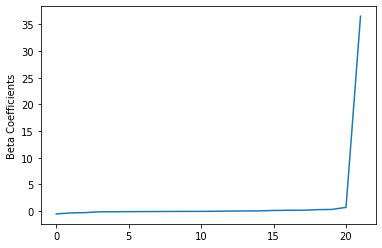

In [210]:
beta = np.sort(lr_trained_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


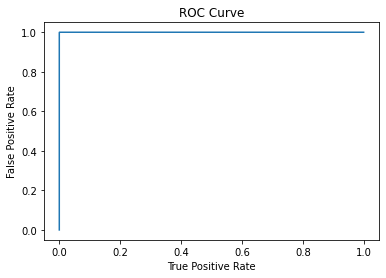

Training set areaUnderROC: 0.999999550110088


In [211]:
trainingSummary = lr_trained_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


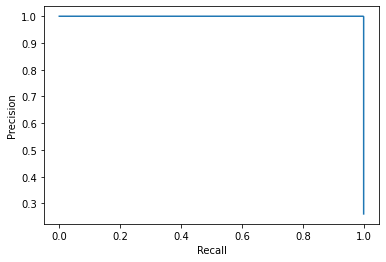

In [212]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [213]:
predictions = lr_trained_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='LabelIndex')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


#Model before preprocessing

In [214]:
df = spark.read.csv(customer_file_path, inferSchema=True, header=True)

In [215]:
df = df.na.drop()

In [216]:
categorical_cols = {'gender', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                    'PaymentMethod', 'Label', "Contract", "customerID"}

In [217]:
stages = list()
for column in categorical_cols:
    string_indexer = StringIndexer(inputCol=column, outputCol=column+"Index")
    stages.append(string_indexer)

pipeline = Pipeline(stages=stages)
normalized_model = pipeline.fit(df.na.drop())
df = normalized_model.transform(df.na.drop())

In [218]:
vector_col = "features"
columns = [column+"Index" for column in categorical_cols] + ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
columns.remove('LabelIndex')
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df = assembler.transform(df)

In [219]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Label',
 'MultipleLinesIndex',
 'ContractIndex',
 'customerIDIndex',
 'PhoneServiceIndex',
 'genderIndex',
 'PaymentMethodIndex',
 'InternetServiceIndex',
 'PartnerIndex',
 'OnlineSecurityIndex',
 'DependentsIndex',
 'DeviceProtectionIndex',
 'PaperlessBillingIndex',
 'LabelIndex',
 'StreamingMoviesIndex',
 'TechSupportIndex',
 'StreamingTVIndex',
 'OnlineBackupIndex',
 'features']

In [220]:
train, test = df.randomSplit([0.8, 0.2], 42)

In [221]:
logistic_regression = LogisticRegression(featuresCol='features', labelCol='LabelIndex', maxIter=30)
lr_trained_model = logistic_regression.fit(train)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


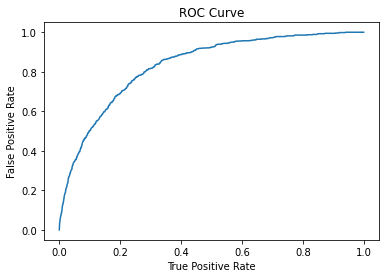

Training set areaUnderROC: 0.8327346769189856


In [222]:
trainingSummary = lr_trained_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


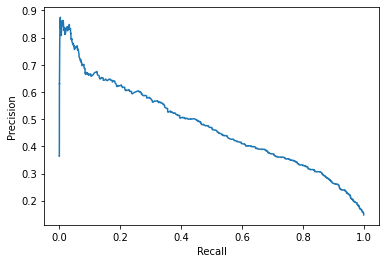

In [224]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [223]:
predictions = lr_trained_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='LabelIndex')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.833292152387083
